In [76]:
!pip install pandas_datareader

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [78]:
df = pd.read_csv('s3://stockdata4188/stocks/AAPL.csv', sep=',', encoding='utf-8')

In [79]:
df.columns
df.isnull().sum()/df.shape[0] * 100
#Checks the percentage of data having null entities within the column

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

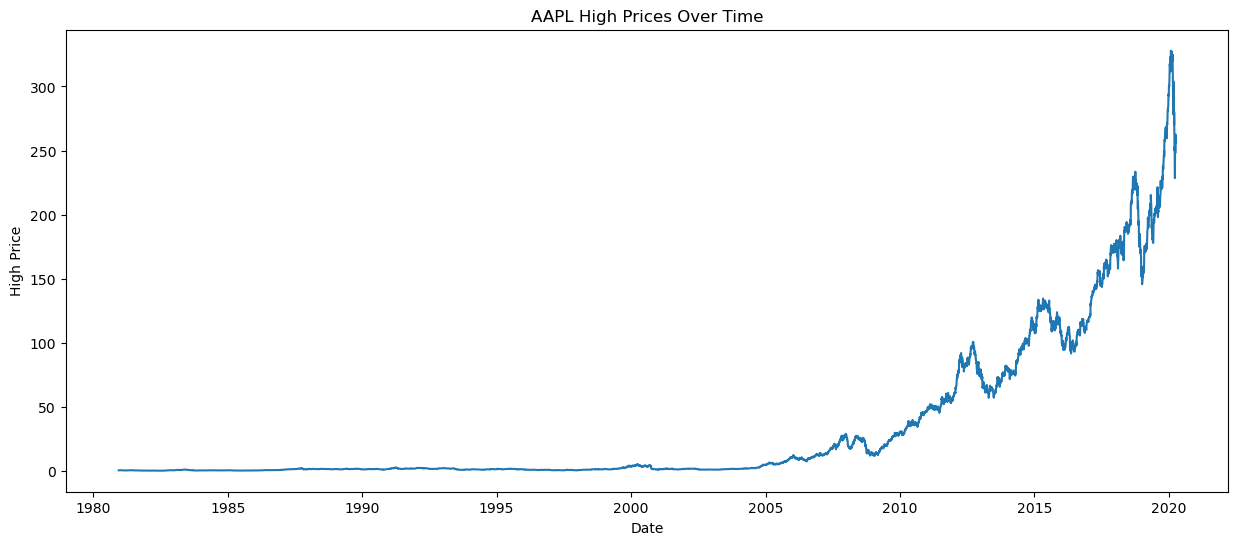

In [80]:
df.dropna(inplace=True)
df2 = df[['Date', 'High']].copy()
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
plt.figure(figsize=(15, 6))
plt.plot(df2['High'])
plt.title('AAPL High Prices Over Time')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.show()

/tmp/ipykernel_7826/3242822377.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_returns.iloc[1:], bins=50, fit=norm, kde=False)


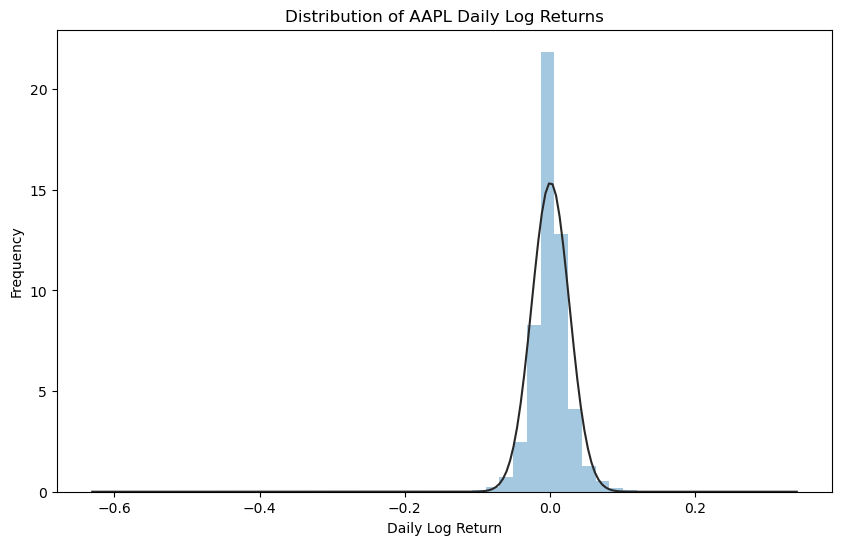

In [81]:
# Compute log returns directly
log_returns = np.log(df2['High'] / df2['High'].shift(1))

# Plot the distribution of log returns (excluding the first row)
plt.figure(figsize=(10, 6))
sns.distplot(log_returns.iloc[1:], bins=50, fit=norm, kde=False)
plt.xlabel("Daily Log Return")
plt.ylabel("Frequency")
plt.title("Distribution of AAPL Daily Log Returns")
plt.show()

In [82]:
#Compute the Mean,Variance, Daily Returns and Drift
mean = log_returns.mean()
stdev = log_returns.std()
var = log_returns.var()
drift = mean - (0.5 * var)

In [83]:
days = 50
trials = 10000

Z = norm.ppf(np.random.rand(days, trials))  # Generate random numbers for Z
daily_returns = np.exp(drift + stdev * Z)

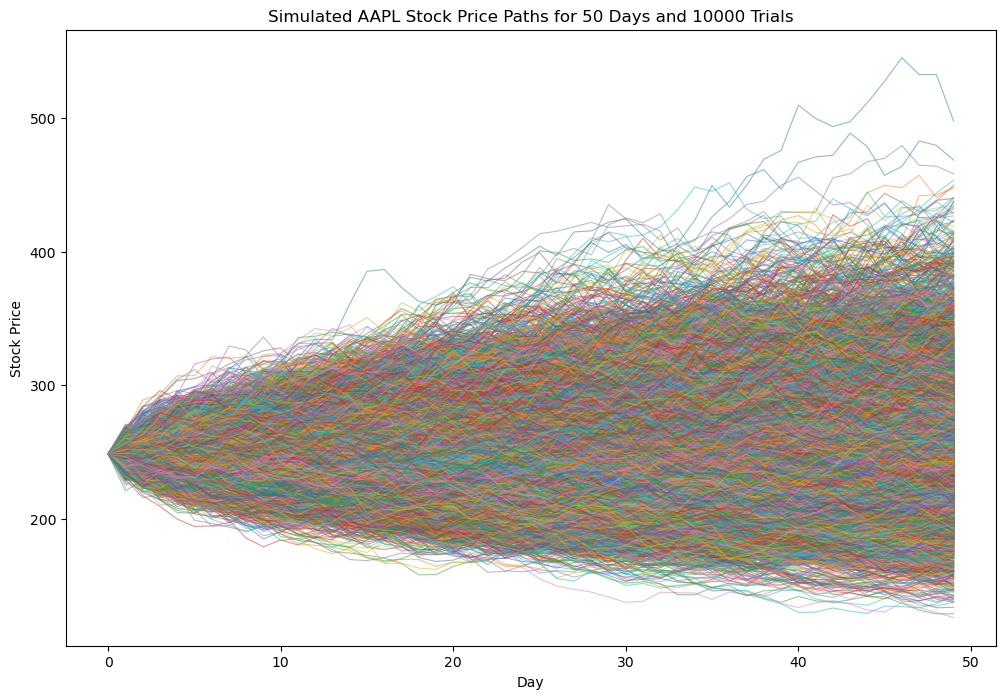

In [84]:
#Calculating the stock price for every trial
price_paths = np.zeros_like(daily_returns)
price_paths[0] = df2.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]
plt.figure(figsize=(12, 8))
for i in range(trials):
    plt.plot(price_paths[:, i], lw=0.8, alpha=0.5)

plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Simulated AAPL Stock Price Paths for {} Days and {} Trials".format(days, trials))
plt.show()


In [85]:
def log_returns(data):
    return np.log(data / data.shift(1))
log_return = log_returns(df2)
print(log_return)

                High
Date                
1980-12-12       NaN
1980-12-15 -0.053346
1980-12-16 -0.075866
1980-12-17  0.024332
1980-12-18  0.028438
...              ...
2020-03-26  0.001664
2020-03-27 -0.010922
2020-03-30 -0.001369
2020-03-31  0.026912
2020-04-01 -0.053885

[9909 rows x 1 columns]


In [86]:
def drift_calc(data):
    lr = log_returns(data)
    mean = lr.mean()
    var = lr.var()
    drift = mean - (0.5 * var)
    return drift
print(drift_calc(df2))

High    0.000286
dtype: float64


In [87]:
def daily_returns(data, days, iterations):
    ft = drift_calc(data)
    stv = log_returns(data).std()  # Get the standard deviation as a scalar float
    Z = norm.ppf(np.random.rand(days, iterations))
    dr = np.exp(ft + stv * Z)
    return dr
#print(daily_returns(df2, 50, 1000))

In [88]:
def beta_sharpe(data, riskfree=0.025):
    # Calculate logarithmic returns for 'High' prices
    log_ret = log_returns(data)
    
    # Calculate covariance matrix and market variance
    covar = log_ret.cov() * 252  # Annualized covariance matrix
    market_var = log_ret.mean() * 252  # Annualized market variance
    
    # Calculate beta
    beta = covar / market_var
    
    # Calculate standard deviation of stock returns
    stdev_ret = log_ret.std() * np.sqrt(252)
    
    # Prepare beta and standard deviation as scalars
    beta_val = beta.iloc[0, 0]  # Extract scalar value from DataFrame
    stdev_val = stdev_ret.iloc[0]  # Extract scalar value from Series
    
    # Prepare beta and standard deviation DataFrame
    beta_df = pd.DataFrame({'Beta': [beta_val], 'STD': [stdev_val]})
    
    # Calculate CAPM and Sharpe ratio
    market_ret = log_ret.mean() * 252  # Annualized market return
    beta_df['CAPM'] = riskfree + beta_df['Beta'] * (market_ret - riskfree)
    beta_df['Sharpe'] = (beta_df['CAPM'] - riskfree) / beta_df['STD']
    
    return beta_df

# Example:
# Generate random 'High' prices DataFrame
np.random.seed(0)
df2 = pd.DataFrame({'High': np.random.randint(100, 200, size=100)})

# Calculate beta and Sharpe ratio metrics
beta_sharpe_metrics = beta_sharpe(df2)

print("Beta and Sharpe Ratio Metrics:")
print(beta_sharpe_metrics)

Beta and Sharpe Ratio Metrics:
         Beta       STD  CAPM  Sharpe
0  282.133571  4.435854   NaN     NaN


In [89]:
def probs_find(predicted, higherthan, on='value'):
    if on not in ['value', 'return']:
        print("'on' must be either 'value' or 'return'")
        return None
    
    if on == 'return':
        predicted0 = predicted.iloc[0, 0]  # Initial value for return calculation
        predicted_values = predicted.iloc[-1].values  # Extract final predicted values
        over = [(i - predicted0) / predicted0 >= higherthan for i in predicted_values]
        over_count = sum(over)
        total_count = len(predicted_values)
        probability = over_count / total_count if total_count > 0 else 0
    elif on == 'value':
        predicted_values = predicted.iloc[-1].values  # Extract final predicted values
        over = [i >= higherthan for i in predicted_values]
        over_count = sum(over)
        total_count = len(predicted_values)
        probability = over_count / total_count if total_count > 0 else 0
    
    return probability
np.random.seed(0)
data = np.random.randint(100, 200, size=(10, 3))
predicted = pd.DataFrame(data, columns=['Day 1', 'Day 2', 'Day 3'])

# Calculate probability of values being higher than 0.2 based on 'return' (percentage change)
probability_return = probs_find(predicted, 0.2, on='return')
print("Probability of return being higher than 20%:", probability_return)

# Calculate probability of values being higher than 200 based on 'value'
probability_value = probs_find(predicted, 180, on='value')
print("Probability of value being higher than 180:", probability_value)


Probability of return being higher than 20%: 0.6666666666666666
Probability of value being higher than 180: 0.3333333333333333


/tmp/ipykernel_7826/2701759877.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_prices, ax=ax[0])
/tmp/ipykernel_7826/2701759877.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_prices, hist_kws={'cumulative': True}, kde_kws={'cumulative': True}, ax=ax[1])


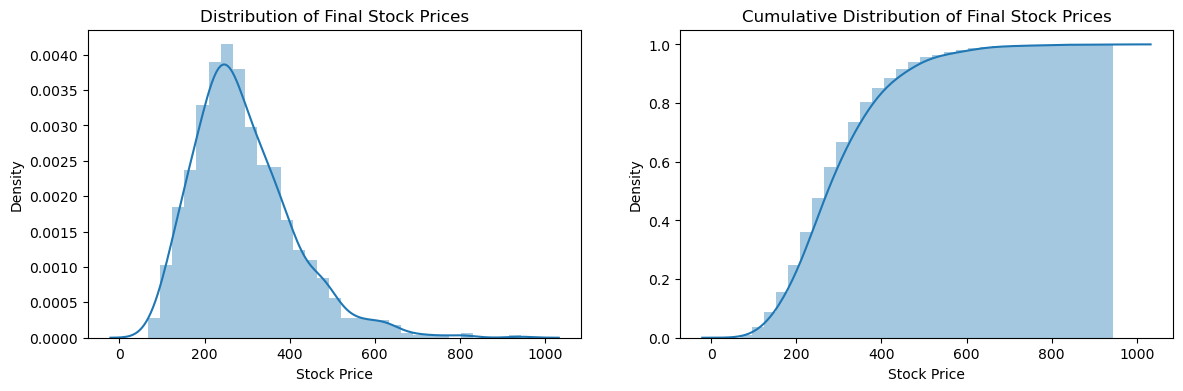

Simulation Details:
Days: 251
Expected Value: $291.73
Return: 14.74%


0           1           2           3           4           5    \
0    248.720001  248.720001  248.720001  248.720001  248.720001  248.720001   
1    250.313879  234.221134  248.399846  252.368740  238.008160  256.483451   
2    256.196542  233.923574  248.846013  248.068554  239.729172  253.141716   
3    254.827502  236.009531  253.927563  254.953124  245.479535  246.917097   
4    251.313974  237.106331  246.898733  252.482007  235.468340  245.020726   
..          ...         ...         ...         ...         ...         ...   
247  259.543612  171.465836  318.515794  745.406093  343.689466  501.222250   
248  269.859750  173.565262  322.210473  738.322394  343.359655  491.717952   
249  265.674061  172.747431  325.218204  784.484282  356.442328  497.757988   
250  261.653653  167.543221  330.703641  796.408906  365.112680  493.738130   
251  264.701733  167.184412  351.904620  807.162162  350.810634  479.979067   

            6           7           8           9    ...         990  \
0    248.720001  248.720001  248.720001  248.720001  ...  248.720001   
1    249.116810  236.991418  243.945989  259.896006  ...  242.781597   
2    250.452879  231.250059  237.781590  258.560003  ...  234.250822   
3    256.767282  222.096122  232.711544  260.746004  ...  232.553058   
4    248.930052  223.059035  234.981140  276.362808  ...  227.475304   
..          ...         ...         ...         ...  ...         ...   
247  299.067708  421.129464  313.809042  342.408019  ...  224.188488   
248  295.437011  412.085542  315.852126  364.470760  ...  215.276745   
249  301.724179  425.556623  299.550357  350.045879  ...  223.640281   
250  309.610835  420.322770  303.495416  343.068010  ...  219.526356   
251  309.919669  415.283734  315.571001  342.507824  ...  225.606332   

            991         992         993         994         995         996  \
0    248.720001  248.720001  248.720001  248.720001  248.720001  248.720001   
1    256.341768  236.712821  251.476368  247.398767  254.085538  252.608766   
2    256.001581  233.354336  259.331230  243.844621  264.728174  253.442747   
3    251.457701  228.111196  257.785475  236.581610  262.160975  252.438128   
4    246.557840  223.943657  251.091050  239.767826  256.988356  247.826684   
..          ...         ...         ...         ...         ...         ...   
247  204.713942  127.225788  290.433021  369.140116  284.611625  467.661433   
248  199.890964  128.303604  278.098965  372.944427  273.201088  491.130788   
249  197.029371  124.422863  278.635477  373.259448  281.713600  479.898997   
250  204.744872  128.629630  282.249733  364.114748  277.082280  493.702841   
251  203.829710  132.045570  274.327927  360.292926  291.701157  485.069782   

            997         998         999  
0    248.720001  248.720001  248.720001  
1    248.469190  251.185410  248.819971  
2    245.604354  257.138831  252.254849  
3    251.838084  267.408410  249.068429  
4    246.404485  265.707580  260.618528  
..          ...         ...         ...  
247  347.007832  247.937121  377.562757  
248  357.090563  253.162448  388.610970  
249  357.256264  256.458930  379.751747  
250  346.816091  260.116016  372.187192  
251  353.547551  248.534730  359.784052  

[252 rows x 1000 columns]

In [90]:
def simulate_mc(data, days, iterations, plot=True):
    returns = daily_returns(data, days, iterations)
    price_list = np.zeros((days, iterations))  # Initialize an array for price simulation
    
    # Set initial prices in the price_list array
    price_list[0] = data.iloc[-1]  # Use the last available price as the initial price
    
    # Simulate stock prices for each day
    for t in range(1, days):
        price_list[t] = price_list[t-1] * returns[t]
    
    if plot:
        final_prices = pd.DataFrame(price_list[-1])  # Extract final simulated prices
        # Plot distribution and cumulative distribution of final stock prices
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        sns.distplot(final_prices, ax=ax[0])
        sns.distplot(final_prices, hist_kws={'cumulative': True}, kde_kws={'cumulative': True}, ax=ax[1])
        ax[0].set_xlabel("Stock Price")
        ax[0].set_title("Distribution of Final Stock Prices")
        ax[1].set_xlabel("Stock Price")
        ax[1].set_title("Cumulative Distribution of Final Stock Prices")
        plt.show()
    
    print("Simulation Details:")
    print(f"Days: {days - 1}")
    print(f"Expected Value: ${round(final_prices.mean().values[0], 2)}")
    
    initial_price = price_list[0, 0]
    final_price = final_prices.mean().values[0]
    return_percentage = 100 * (final_price - initial_price) / final_price
    print(f"Return: {round(return_percentage, 2)}%")
    
    return pd.DataFrame(price_list)

# Example:
np.random.seed(0)
data = df['High']  # Use the 'High' column from your dataset

simulate_mc(data, days=252, iterations=1000)